In [1]:
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
cfg = {
    'DIR': '../dataset/',
    'train_path': 'train.json',
    'test_path': 'test.json',
    'dev_path': 'dev.json',
}

In [3]:
from nltk import word_tokenize

def tokenize(str: str) -> str:
    return ' '.join(word_tokenize(str))

In [4]:
import os

def load_data(path: str) -> json:
    with open(os.path.join(cfg['DIR'], path), 'r') as f:
        data = json.load(f)
    return data

In [5]:
import re

def clean_str(str: str) -> str:
    # remove '\n' character
    str = str.replace('\n', ' ')
    # remove '\t' character
    str = re.sub(r'\\t', ' ', str)
    # remove '\r' character
    str = re.sub(r'\\r', ' ', str)
    # remove more than 2 consecutive occcurance of a character
    str = re.sub(r'(.)\1{2,}', r'\1', str)
    return str.strip().lower()

In [6]:
def clean_data(data: dict) -> None:
    for i in range(len(data['documents'])):
        data['documents'][i]['text'] = clean_str(data['documents'][i]['text'])
        data['documents'][i]['text'] = tokenize(data['documents'][i]['text'])

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_XY(data: dict, tfidf: TfidfVectorizer, hypothesis: dict, labels: dict) -> (list, list):
    
    X = []
    Y = []
    for i in range(len(data["documents"])):
        premise = data["documents"][i]["text"]
        # convert premise to tf-idf
        premise_vector = tfidf.transform([premise]).toarray().tolist()[0]
        for key, val in hypothesis.items():
            # convert hypothesis to tf-idf
            hypothesis_vector = tfidf.transform([val]).toarray().tolist()[0]
            # concatenate premise and hypothesis
            X += [premise_vector + hypothesis_vector]
            Y += [labels[data["documents"][i]["annotation_sets"][0]["annotations"][key]["choice"]]]
    return X, Y

In [8]:
def get_hypothesis(data: dict) -> list:
    hypothesis = {}
    for key, value in data['labels'].items():
        hypothesis[key] = clean_str(value['hypothesis'])
    return hypothesis

In [9]:
from sklearn.preprocessing import LabelEncoder

def get_labels() -> dict:
    return {
        'NotMentioned': 0,
        'Entailment': 1,
        'Contradiction': 2,
    }

In [10]:
train = load_data(cfg['train_path'])
clean_data(train)
hypothesis = get_hypothesis(train)
labels = get_labels()

In [11]:
all_text = ""

for i in range(len(train["documents"])):
    all_text += train["documents"][i]["text"] + " "

tfidf = TfidfVectorizer()
tfidf.fit([all_text])

TfidfVectorizer()

In [12]:
X_train, Y_train = get_XY(train, tfidf, hypothesis, labels=labels)

In [28]:
from sklearn.svm import SVC

model = SVC(kernel='linear')
model.fit(X_train[:2000], Y_train[:2000])

SVC(kernel='linear')

In [15]:
dev = load_data(cfg['dev_path'])
clean_data(dev)
X_dev, Y_dev = get_XY(dev, tfidf, hypothesis, labels=labels)

In [29]:
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

wandb.init(entity="contract-nli-db", project="doc_tf-if_svm")
config = wandb.config

config.kernel = 'linear'
config.train_size = 2000
config.dev_size = len(X_dev)

wandb.log({'accuracy': model.score(X_dev, Y_dev)})

Y_pred = model.predict(X_dev)
report = classification_report(Y_dev, Y_pred, output_dict=True)
wandb.log(report)

wandb: Currently logged in as: shu7bh (contract-nli-db). Use `wandb login --relogin` to force relogin


cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


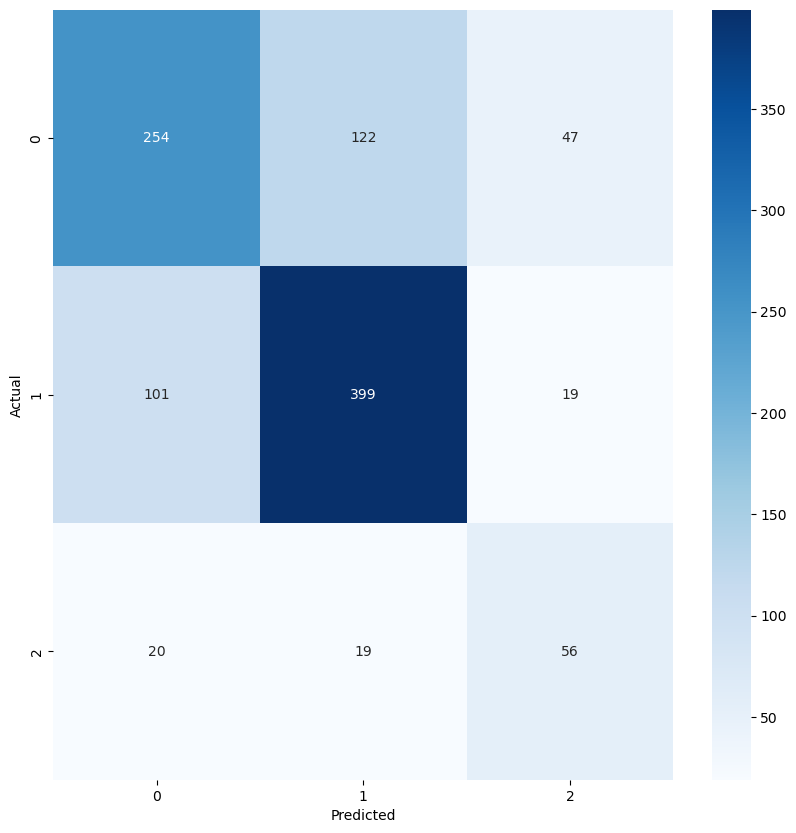

In [30]:
cm = confusion_matrix(Y_dev, Y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('doc_tf-idf_svm.png')
wandb.log({'confusion_matrix': wandb.Image('doc_tf-idf_svm.png')})

In [32]:
wandb.finish()

In [33]:
# remove the png file
os.remove('doc_tf-idf_svm.png')